## Data cleaning
In this notebook, I clean the dataset retrieved from the ISC-EHB catalog. 

In [149]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from obspy.core import UTCDateTime # this is a very convenient function!

%matplotlib inline

In [301]:
fname1 = '/Users/jgra0019/Documents/phd_data/focal_meca/ISC_data/1976_2018_latest_isc_data.csv'
fname2 = '/Users/jgra0019/Documents/phd_data/focal_meca/ISC_data/1976_2018_isc_only_new.csv'

gcmt_df = pd.read_csv(fname1, header = 'infer')
isc_df = pd.read_csv(fname2, header = 'infer')

# Earthquake catalog preparation
The authors for origin and focal mechanism are not necessarily the same. For my analysis, I use the origin values from ISC and the focal mechanism is from GCMT.

In [302]:
# these are the entries with centroid moment tensor by GCMT
print(gcmt_df[gcmt_df['AUTHOR.1'] == 'GCMT'].shape)

(5589, 35)


In [303]:
gcmt_df = gcmt_df[gcmt_df['AUTHOR.1'] == 'GCMT']

print('Before dropping duplicate events: ')
print(isc_df.shape)
print(gcmt_df.shape)

isc_df = isc_df.drop_duplicates(subset='EVENTID', keep = 'last') # keep last (probably updates)
gcmt_df = gcmt_df.drop_duplicates(subset='EVENT_ID', keep = 'last') 

print('After dropping duplicate events: ')
print(isc_df.shape)
print(gcmt_df.shape)

Before dropping duplicate events: 
(18448, 9)
(5589, 35)
After dropping duplicate events: 
(18448, 9)
(5588, 35)


In [304]:
isc_df = isc_df[isc_df.DEPQUAL.isin(['L1', 'L2'])] # remove the events with large uncertainty
isc_df = isc_df.reset_index(drop=True)
gcmt_df.sort_values(by = 'MW', ascending = False, inplace = True) # sort by largest Mw first - prioritized
gcmt_df = gcmt_df.reset_index(drop=True)
#print(isc_df.shape)

(12625, 9)


# Earthquake catalog preparation
Results indicate that the difference in time from the two datasets should be up to 3 mins only. 
Also, you can use the Mw as an additional threshold.

In [403]:
# Use the date and time to connect the events
gcmt_copy = gcmt_df.copy(deep = True)
isc_copy = isc_df.copy(deep = True)
isc_match = pd.DataFrame() # dataframe containing the results of the search

gcmt_dummy = np.array(gcmt_df['DATE'] + ' ' + gcmt_df['TIME'])
isc_dummy = np.array(isc_df['DATE'] + ' ' + isc_df['TIME'])

gcmt_ev_time = []
isc_ev_time = []
gcmt_to_rm = []

for val in gcmt_dummy:
    gcmt_ev_time.append(UTCDateTime(val))
    
for val in isc_dummy:
    isc_ev_time.append(UTCDateTime(val))

gcmt_ev_time = np.array(gcmt_ev_time)
isc_ev_time = np.array(isc_ev_time)

# see the time difference and then solve for the Mw difference
#based on large events: max lon lat diff: 1.7; time diff: 60 sec
deg_thresh = 1.7
sec_thresh = 150

# get the isc and gcmt indices here
# linking algorithm works like this:
# Prioritize large events in the gcmt catalogue
# Links events in the GCMT and ISC catalogue by looking at the time and location
for i, gcmt_r in gcmt_copy.iterrows(): # loop over gcmt
    
    #val = gcmt_df.iloc[0]
    gcmt_dummy = gcmt_r['DATE'] + ' ' + gcmt_r['TIME']
    gcmt_time = UTCDateTime(gcmt_dummy)

    subset_df = isc_copy[(np.abs(gcmt_r['LON'] - isc_copy['LON']) <= deg_thresh) & (np.abs(gcmt_r['LAT'] - isc_copy['LAT']) <= deg_thresh)]

    t_min = sec_thresh + 1
    row_rep = None
    idx_rep = None
    
    for j, subset_r in subset_df.iterrows():
    
        dummy = subset_r['DATE'] + ' ' + subset_r['TIME']
        t_diff = np.abs(gcmt_time - UTCDateTime(dummy))

        #print(t_diff) # a bit convoluted, so additional explanation
        if t_diff < t_min:
            t_min = t_diff
            row_rep = subset_r
            idx_rep = j  
            
    if t_min < sec_thresh:
        isc_match = isc_match.append(row_rep, ignore_index = True) 
        isc_copy = isc_copy.drop(index = idx_rep)
    else: # if row_rep is None or no event close enough is found then list the index as one to be removed from gcmt
        gcmt_to_rm.append(i)
    
    
gcmt_copy = gcmt_copy.drop(index = gcmt_to_rm)

In [412]:
isc_match.head()

,AUTHOR,DATE,DEPFIX,DEPQUAL,DEPTH,EVENTID,LAT,LON,TIME
0,ISC-EHB,2004-12-26,1.0,L2,28.6,610813174.0,3.299,95.876,00:58:53.15
1,ISC-EHB,2005-03-28,1.0,L2,25.8,610815812.0,3.026,97.459,16:09:43.04
2,ISC-EHB,2012-04-11,NaN,L1,17.7,610853793.0,2.319,93.061,08:38:36.21
3,ISC-EHB,2007-09-12,NaN,L1,32.0,610827909.0,-4.458,101.359,11:10:26.21
4,ISC-EHB,1977-08-19,NaN,L1,15.9,615808278.0,-11.121,118.371,06:08:53.93


In [413]:
gcmt_copy.head()

,EVENT_ID,AUTHOR,DATE,TIME,LAT,LON,DEPTH,CENTROID,AUTHOR.1,EX,...,EX.2,T_VAL,T_PL,T_AZM,P_VAL,P_PL,P_AZM,N_VAL,N_PL,N_AZM
0,7453151,GCMT,2004-12-26,01:01:09.00,3.09,94.26,28.6,True,GCMT,22.0,...,22.0,4.015,52.0,36.0,-3.892,38.0,222.0,-0.119,3.0,130.0
1,7486110,GCMT,2005-03-28,16:10:31.50,1.67,97.07,25.8,True,GCMT,22.0,...,22.0,1.050,52.0,30.0,-1.049,38.0,218.0,-0.002,4.0,125.0
2,600860404,GCMT,2012-04-11,08:38:36.70,2.35,92.82,45.6,True,GCMT,22.0,...,22.0,0.862,13.0,243.0,-0.966,6.0,335.0,0.104,75.0,88.0
3,13203322,GCMT,2007-09-12,11:11:14.80,-3.78,100.99,24.4,True,GCMT,21.0,...,21.0,6.722,53.0,29.0,-6.701,37.0,216.0,-0.024,3.0,123.0
4,694739,GCMT,1977-08-19,06:09:32.20,-11.14,118.23,23.3,True,GCMT,21.0,...,21.0,3.710,21.0,157.0,-3.470,67.0,317.0,-0.240,7.0,64.0


In [411]:
# remove elements from gcmt_copy

isc_match = isc_match.reset_index(drop=True)
gcmt_copy = gcmt_copy.reset_index(drop = True) 



In [426]:
#cmt_df = pd.concat([isc_match, gcmt_copy], join_axes = 1, ignore_index = True)
cmt_df = pd.merge(isc_match, gcmt_copy, left_index = True, right_index = True)
print(cmt_df.shape)

(4848, 44)


In [433]:
# check to make sure that the dataset has enough time coverage

gcmt_dummy = np.array(gcmt_copy['DATE'] + ' ' + gcmt_copy['TIME'])
isc_dummy = np.array(isc_match['DATE'] + ' ' + isc_match['TIME'])

gcmt_ev_time = []
isc_ev_time = []

for val in gcmt_dummy:
    gcmt_ev_time.append(UTCDateTime(val))
    
for val in isc_dummy:
    isc_ev_time.append(UTCDateTime(val))
    
ref_date = gcmt_ev_time[0]

gcmt_ev_time = np.array(gcmt_ev_time)
isc_ev_time = np.array(isc_ev_time)

date1 = []
date2 = []

for val in gcmt_ev_time:
    date1.append(val - ref_date)

for val in isc_ev_time:
    date2.append(val - ref_date)
    
date1 = np.array(date1)
date2 = np.array(date2)

(array([  64.,  110.,   69.,   87.,  141.,  101.,   86.,  122.,  148.,
         143.,  138.,  137.,  121.,  174.,  174.,  162.,  382.,  762.,
         339.,  294.,  258.,  281.,  322.,  233.]),
 array([-28.94466444, -27.23829251, -25.53192057, -23.82554864,
        -22.11917671, -20.41280478, -18.70643285, -17.00006092,
        -15.29368898, -13.58731705, -11.88094512, -10.17457319,
         -8.46820126,  -6.76182933,  -5.05545739,  -3.34908546,
         -1.64271353,   0.0636584 ,   1.77003033,   3.47640227,
          5.1827742 ,   6.88914613,   8.59551806,  10.30188999,  12.00826192]),
 <a list of 24 Patch objects>)

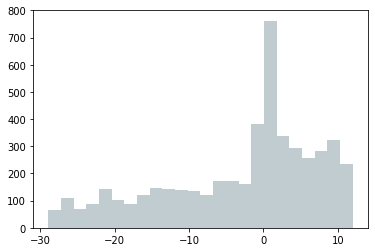

In [434]:
plt.hist(date1/31536000, bins = 'fd', alpha = 0.3)
plt.hist(date2/31536000, bins = 'fd', alpha = 0.1)

In [436]:
gcmt_copy.columns

Index(['EVENT_ID', 'AUTHOR', 'DATE', 'TIME', 'LAT', 'LON', 'DEPTH', 'CENTROID',
       'AUTHOR.1', 'EX', 'MO', 'MW', 'EX.1', 'MRR', 'MTT', 'MPP', 'MRT', 'MTP',
       'MPR', 'STRIKE', 'DIP', 'RAKE', 'STRIKE.1', 'DIP.1', 'RAKE.1', 'EX.2',
       'T_VAL', 'T_PL', 'T_AZM', 'P_VAL', 'P_PL', 'P_AZM', 'N_VAL', 'N_PL',
       'N_AZM'],
      dtype='object')

In [438]:
final1 = isc_match[['LON', 'LAT', 'DEPTH', 'DATE', 'TIME', 'DEPFIX', 'DEPQUAL']] # from isc
final1 = final1.reset_index(drop=True) 
final2 = gcmt_copy[['EX', 'MO', 'MW', 'EX.1', 'MRR', 'MTT', 'MPP', 'MRT', 'MTP',
       'MPR', 'STRIKE', 'DIP', 'RAKE', 'STRIKE.1', 'DIP.1', 'RAKE.1', 'EX.2',
       'T_VAL', 'T_PL', 'T_AZM', 'P_VAL', 'P_PL', 'P_AZM', 'N_VAL', 'N_PL',
       'N_AZM']] # from gcmt
final2 = final2.reset_index(drop=True) # drop = True is actually important

In [439]:
# remove earthquakes from the Philippines

final_df = pd.concat([final1, final2], axis = 1)

final_df = final_df[~((final_df['LAT'] >= 0) & (final_df['LON'] >= 115))]
                    
final_df = final_df.reset_index(drop=True) # this is actually important
print(final_df.shape)

(3308, 33)


In [446]:
final_df.sort_values(by = 'MW', inplace = True, ascending = False)
final_df = final_df.reset_index(drop=True) # this is actually important
print(final_df.shape)

(3308, 33)


In [447]:
out_fname = '/Users/jgra0019/Documents/phd_data/focal_meca/ISC_data/revised_isc_gcmt_data.csv'
final_df.to_csv(out_fname, sep = ',', index = False)